[INFO] Alex prediction seems overdensity (δ). Applying ρ = δ + 1 correction.


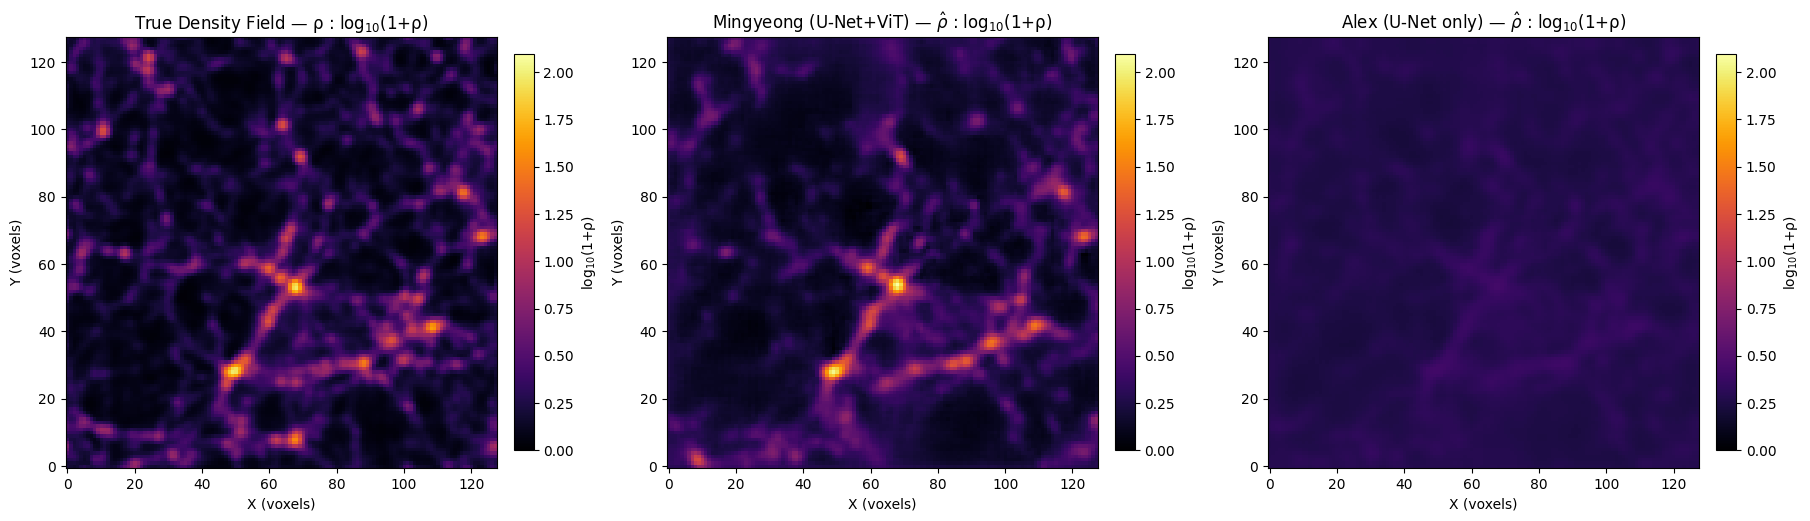

[INFO] Saved figure: compare_true_ming_alex_INDEX100.png
[INFO] True : /scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/100.hdf5
[INFO] Ming : /home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251014_210016/100.hdf5
[INFO] Alex : /scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/predictions/test_100_final_mode0_lr_min1e-07_max1e-05_200epochs_rho_240712_a100_cmb_f2.5.npy


In [1]:
# -*- coding: utf-8 -*-
"""
Compare 3 maps side-by-side:
  1. True density (ρ_true)
  2. Mingyeong (U-Net+ViT)
  3. Alex (U-Net only)
All displayed in log10(1+ρ) scale with common vmin/vmax.
"""

import os, glob, h5py
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# User settings
# ===============================
INDEX = 100
SLICE_AXIS = 2              # 0,1,2 중 선택
SLICE_INDEX_MODE = "center" # "center" 또는 int
SAVE_FIG = True
OUTFIG = f"compare_true_ming_alex_INDEX{INDEX}.png"

# 파일 경로
TEST_FILE = f"/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/{INDEX}.hdf5"
PRED_DIR  = "/home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251014_210016"
MING_FILE = os.path.join(PRED_DIR, f"{INDEX}.hdf5")
ALEX_PRED_PATTERN_TPL = "/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/predictions/test_{idx}_final_*.npy"

# ===============================
# Utilities
# ===============================
def _safesqueeze(a):
    a = np.squeeze(np.asarray(a))
    if a.ndim < 3:
        raise ValueError(f"Unexpected ndim {a.ndim} for shape {a.shape}")
    return a

def _get_slice(vol3d, axis=2, idx="center"):
    if idx == "center":
        idx = vol3d.shape[axis] // 2
    if axis == 0:   return vol3d[idx,:,:]
    elif axis == 1: return vol3d[:,idx,:]
    elif axis == 2: return vol3d[:,:,idx]
    else: raise ValueError("axis must be 0,1,2")

def _log10p(a):
    return np.log10(1.0 + np.clip(a, 0, None))

# ===============================
# Load true density
# ===============================
with h5py.File(TEST_FILE, "r") as f:
    rho_true = _safesqueeze(f["output_rho"][:])  # (D,H,W)

# ===============================
# Load Mingyeong prediction
# ===============================
with h5py.File(MING_FILE, "r") as f:
    rho_ming = _safesqueeze(f["prediction"][:])

# ===============================
# Load Alex prediction (NPY)
# ===============================
npy_pattern = ALEX_PRED_PATTERN_TPL.format(idx=INDEX)
npy_list = sorted(glob.glob(npy_pattern))
if len(npy_list) == 0:
    raise FileNotFoundError(f"No Alex npy found: {npy_pattern}")
ALEX_FILE = npy_list[0]
rho_alex = _safesqueeze(np.load(ALEX_FILE))

# ===============================
# Heuristic: detect overdensity (δ) vs absolute ρ
# ===============================
alex_min, alex_max = rho_alex.min(), rho_alex.max()
assume_overdensity = alex_min < 0 or alex_max < 1.0
if assume_overdensity:
    print(f"[INFO] Alex prediction seems overdensity (δ). Applying ρ = δ + 1 correction.")
    rho_alex = rho_alex + 1.0

# ===============================
# Slice extraction
# ===============================
rho_t_slice = _get_slice(rho_true, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
rho_m_slice = _get_slice(rho_ming, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
rho_a_slice = _get_slice(rho_alex, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)

# ===============================
# Visualization transform (log10(1+ρ))
# ===============================
true_img = _log10p(rho_t_slice)
ming_img = _log10p(rho_m_slice)
alex_img = _log10p(rho_a_slice)

# 공통 색상 스케일
vmin = min(true_img.min(), ming_img.min(), alex_img.min())
vmax = max(true_img.max(), ming_img.max(), alex_img.max())

# ===============================
# Plot (1×3)
# ===============================
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

titles = [
    "True Density Field — ρ : log$_{10}$(1+ρ)",
    "Mingyeong (U-Net+ViT) — $\hat{\\rho}$ : log$_{10}$(1+ρ)",
    "Alex (U-Net only) — $\hat{\\rho}$ : log$_{10}$(1+ρ)"
]
images = [true_img, ming_img, alex_img]

for ax, img, title in zip(axes, images, titles):
    im = ax.imshow(img, origin="lower", cmap="inferno", vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel("X (voxels)")
    ax.set_ylabel("Y (voxels)")
    cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label("log$_{10}$(1+ρ)")

if SAVE_FIG:
    plt.savefig(OUTFIG, dpi=200)
plt.show()

print(f"[INFO] Saved figure: {OUTFIG}")
print(f"[INFO] True : {TEST_FILE}")
print(f"[INFO] Ming : {MING_FILE}")
print(f"[INFO] Alex : {ALEX_FILE}")


In [2]:
# JUPYTER-FRIENDLY BATCH STATS (sampling-KS + multiprocessing + logging)

import os, re, glob, h5py, logging, math
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial
from tqdm.auto import tqdm

# =========================
# Configuration
# =========================
PRED_DIR = "/home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251014_210016"
TEST_TPL = "/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/{idx}.hdf5"
ALEX_TPL = "/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/predictions/test_{idx}_final_*.npy"

# Runtime options
EPS = 1e-6
RNG_SEED = 42

# KS sampling (increase for more accuracy; decrease for speed)
KS_SAMPLE_N = 50_000
KS_MIN_N    = 10_000

# Parallelism
N_PROCESSES = min(os.cpu_count() or 2, 8)   # gentle cap to avoid I/O contention
CHUNKSIZE   = 4

# Alex output type handling: None (auto δ→ρ), or force True/False
ASSUME_ALEX_OVERDENSITY = None

# Optional saving (set to None to skip)
OUT_PER_INDEX_CSV   = "per_index_stats.csv"
OUT_SUMMARY_CSV     = "summary_ming_alex_all.csv"
OUT_SUMMARY_LATEX   = "summary_ming_alex_all.tex"

# =========================
# Logging (to notebook)
# =========================
logger = logging.getLogger("batch_stats")
if not logger.handlers:
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter("[%(asctime)s] %(levelname)s - %(message)s", datefmt="%H:%M:%S"))
    logger.addHandler(handler)
logger.setLevel(logging.INFO)


# =========================
# Helpers
# =========================
def _safesqueeze(a):
    return np.squeeze(np.asarray(a))

def read_truth(idx: int):
    path = TEST_TPL.format(idx=idx)
    with h5py.File(path, "r") as f:
        return _safesqueeze(f["output_rho"][:]), path

def read_ming(idx: int):
    path = os.path.join(PRED_DIR, f"{idx}.hdf5")
    with h5py.File(path, "r") as f:
        return _safesqueeze(f["prediction"][:]), path

def read_alex(idx: int):
    pats = sorted(glob.glob(ALEX_TPL.format(idx=idx)))
    if not pats:
        raise FileNotFoundError(f"Alex NPY not found for idx={idx}")
    arr = np.load(pats[0])
    return _safesqueeze(arr), pats[0]

def maybe_to_rho_from_delta(arr, force=None):
    """
    Convert δ -> ρ if needed.
    force=True  : always convert (ρ = δ + 1)
    force=False : never convert
    force=None  : heuristic: if min<0 or max<1, consider it δ field
    """
    if force is True:
        return arr + 1.0, True
    if force is False:
        return arr, False
    # auto
    if arr.min() < 0 or arr.max() < 1.0:
        return arr + 1.0, True
    return arr, False

def voxelwise_log_ratio_stats(pred, truth, eps=EPS):
    """Per-sample mean/std of log10(pred/truth) over finite voxels."""
    ratio = np.clip(pred, eps, None) / np.clip(truth, eps, None)
    log_ratio = np.log10(ratio)
    m = np.isfinite(log_ratio)
    if not np.any(m):
        return math.nan, math.nan
    return float(np.mean(log_ratio[m])), float(np.std(log_ratio[m]))

def ks_stat_sampled(pred, truth, sample_n=KS_SAMPLE_N, min_n=KS_MIN_N, rng=None):
    """KS between voxel distributions using random subsamples."""
    a = pred.ravel()
    b = truth.ravel()
    m = np.isfinite(a) & np.isfinite(b)
    a, b = a[m], b[m]
    if a.size == 0 or b.size == 0:
        return math.nan
    rng = rng or np.random.default_rng(RNG_SEED)
    def pick(x):
        if x.size <= min_n:
            return x
        n = min(sample_n, x.size)
        idx = rng.choice(x.size, size=n, replace=False)
        return x[idx]
    return float(ks_2samp(pick(a), pick(b)).statistic)

def collect_indices(pred_dir):
    """Find indices from PRED_DIR/*.hdf5 like '123.hdf5'."""
    out = []
    for fn in os.listdir(pred_dir):
        m = re.match(r"(\d+)\.hdf5$", fn)
        if m:
            out.append(int(m.group(1)))
    return sorted(out)

def process_one_index(idx: int):
    """Worker function (must be top-level for multiprocessing)."""
    try:
        rng = np.random.default_rng(RNG_SEED + idx)
        rho_truth, truth_path = read_truth(idx)
        rho_ming , ming_path  = read_ming(idx)
        rho_alex , alex_path  = read_alex(idx)

        rho_alex, converted = maybe_to_rho_from_delta(rho_alex, force=ASSUME_ALEX_OVERDENSITY)

        m_log_mu, m_log_sd = voxelwise_log_ratio_stats(rho_ming, rho_truth)
        m_ks               = ks_stat_sampled(rho_ming, rho_truth, rng=rng)

        a_log_mu, a_log_sd = voxelwise_log_ratio_stats(rho_alex, rho_truth)
        a_ks               = ks_stat_sampled(rho_alex, rho_truth, rng=rng)

        return {
            "index": idx,
            "truth_path": truth_path,
            "ming_path": ming_path,
            "alex_path": alex_path,
            "alex_delta_to_rho": bool(converted),

            "ming_log_mu": m_log_mu,
            "ming_log_sd": m_log_sd,
            "ming_ks": m_ks,

            "alex_log_mu": a_log_mu,
            "alex_log_sd": a_log_sd,
            "alex_ks": a_ks,

            "status": "ok",
            "error": ""
        }
    except Exception as e:
        return {
            "index": idx,
            "truth_path": "",
            "ming_path": "",
            "alex_path": "",
            "alex_delta_to_rho": False,
            "ming_log_mu": math.nan,
            "ming_log_sd": math.nan,
            "ming_ks": math.nan,
            "alex_log_mu": math.nan,
            "alex_log_sd": math.nan,
            "alex_ks": math.nan,
            "status": "error",
            "error": repr(e)
        }

def _fmt(mu, sd):
    if np.isnan(mu) or np.isnan(sd):
        return "N/A"
    return f"{mu:+.3f} ± {sd:.3f}"

def aggregate(per_index_df: pd.DataFrame) -> pd.DataFrame:
    ok = per_index_df[per_index_df["status"] == "ok"].copy()
    n_ok = len(ok)

    ming_mu_mu = ok["ming_log_mu"].mean()
    ming_mu_sd = ok["ming_log_mu"].std(ddof=0)
    ming_ks_mu = ok["ming_ks"].mean()
    ming_ks_sd = ok["ming_ks"].std(ddof=0)

    alex_mu_mu = ok["alex_log_mu"].mean()
    alex_mu_sd = ok["alex_log_mu"].std(ddof=0)
    alex_ks_mu = ok["alex_ks"].mean()
    alex_ks_sd = ok["alex_ks"].std(ddof=0)

    rows = [
        {
            "Model": "Mingyeong (U-Net+ViT)",
            "⟨log10(ρ_pred/ρ_truth)⟩ ± σ (across samples)": _fmt(ming_mu_mu, ming_mu_sd),
            "KS(ρ_pred, ρ_truth) ± σ (across samples)"   : _fmt(ming_ks_mu, ming_ks_sd),
            "N": int(n_ok),
        },
        {
            "Model": "Alex (U-Net only)",
            "⟨log10(ρ_pred/ρ_truth)⟩ ± σ (across samples)": _fmt(alex_mu_mu, alex_mu_sd),
            "KS(ρ_pred, ρ_truth) ± σ (across samples)"   : _fmt(alex_ks_mu, alex_ks_sd),
            "N": int(n_ok),
        },
    ]
    return pd.DataFrame(rows)

def run_batch(indices=None, n_procs=N_PROCESSES, chunksize=CHUNKSIZE):
    if indices is None:
        indices = collect_indices(PRED_DIR)
    if not indices:
        raise RuntimeError(f"No <index>.hdf5 files found in {PRED_DIR}")

    logger.info(f"Found {len(indices)} indices in PRED_DIR.")
    logger.info(f"Using {n_procs} processes | KS_SAMPLE_N={KS_SAMPLE_N}, KS_MIN_N={KS_MIN_N}")
    logger.info(f"ALEX overdensity handling: {ASSUME_ALEX_OVERDENSITY} (None=auto)")

    # Executor (safe in notebooks)
    results = []
    with ProcessPoolExecutor(max_workers=n_procs) as ex:
        futs = [ex.submit(process_one_index, idx) for idx in indices]
        for fut in tqdm(as_completed(futs), total=len(futs), desc="Per-index"):
            results.append(fut.result())

    results = sorted(results, key=lambda d: d["index"])
    per_idx_df = pd.DataFrame(results)

    # Save diagnostics
    if OUT_PER_INDEX_CSV:
        per_idx_df.to_csv(OUT_PER_INDEX_CSV, index=False)
        logger.info(f"Per-index stats saved: {OUT_PER_INDEX_CSV} "
                    f"| ok={(per_idx_df['status']=='ok').sum()}, error={(per_idx_df['status']=='error').sum()}")

    # Aggregate
    summary_df = aggregate(per_idx_df)
    if OUT_SUMMARY_CSV:
        summary_df.to_csv(OUT_SUMMARY_CSV, index=False)
        logger.info(f"Summary table saved: {OUT_SUMMARY_CSV}\n{summary_df.to_string(index=False)}")
    if OUT_SUMMARY_LATEX:
        summary_df.to_latex(OUT_SUMMARY_LATEX, index=False, escape=False)
        logger.info(f"LaTeX table saved: {OUT_SUMMARY_LATEX}")

    # Quick diagnostics
    errs = per_idx_df[per_idx_df["status"]=="error"][["index","error"]]
    if not errs.empty:
        logger.warning("Some indices failed; first few:\n" + errs.head(5).to_string(index=False))

    conv = per_idx_df[per_idx_df["alex_delta_to_rho"] == True]["index"].tolist()
    if conv:
        logger.info(f"Alex treated as δ→ρ for {len(conv)} indices (first 10): {conv[:10]}")

    return per_idx_df, summary_df


/home/mingyeong/miniconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ===== Cell 1: Heavy compute (parallel gather) =====
import os, re, glob, h5py, logging
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed

# ---------------- Config ----------------
PRED_DIR = "/home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251014_210016"
TEST_TPL = "/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/{idx}.hdf5"
ALEX_TPL = "/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/predictions/test_{idx}_final_*.npy"

ASSUME_ALEX_OVERDENSITY = None    # None(자동), True(항상 δ→ρ), False(변환X)
RNG_SEED = 42

# 샘플 크기/빈 개수(속도↔정확도)
JOINT_SAMPLE = 50_000             # 인덱스당 joint PDF 샘플 수(메모리 절약 위해 낮춤)
PDF_LOG_BINS = 120                # df/dlog10 ρ용 로그 빈 개수
JOINT_LOG_BINS = 120              # joint 2D 히스토그램 로그 빈(가로/세로)

# ξ(r) 설정
VOXEL_SIZE_MPC_H = 205.0 / 250.0  # 격자 간격 [h^-1 Mpc]
MAX_R_MPC_H = 10.0
N_R_BINS = 24

# 병렬
N_PROCS = 4

# 캐시 파일
CACHE_NPZ = "figure5_cache_ming_vs_alex.npz"

# ---------------- Logging ----------------
logger = logging.getLogger("fig5_cache")
if not logger.handlers:
    h = logging.StreamHandler()
    h.setFormatter(logging.Formatter("[%(asctime)s] %(levelname)s - %(message)s", "%H:%M:%S"))
    logger.addHandler(h)
logger.setLevel(logging.INFO)

# ---------------- IO helpers ----------------
def _s(a): return np.squeeze(np.asarray(a))
def _collect_indices(pred_dir):
    return sorted(int(m.group(1)) for fn in os.listdir(pred_dir)
                  if (m:=re.match(r"(\d+)\.hdf5$", fn)))

def _read_truth(idx):
    p = TEST_TPL.format(idx=idx)
    with h5py.File(p, "r") as f:
        rho = _s(f["output_rho"][:])
    return rho

def _read_ming(idx):
    p = os.path.join(PRED_DIR, f"{idx}.hdf5")
    with h5py.File(p, "r") as f:
        pred = _s(f["prediction"][:])
    return pred

def _read_alex(idx):
    pats = sorted(glob.glob(ALEX_TPL.format(idx=idx)))
    if not pats:
        raise FileNotFoundError(f"No Alex npy for idx={idx}")
    return _s(np.load(pats[0]))

def _alex_to_rho(arr, force=None):
    if force is True:  return arr + 1.0
    if force is False: return arr
    return arr + 1.0 if (arr.min() < 0 or arr.max() < 1.0) else arr

# ---------------- math helpers ----------------
def _rand_pairs(truth, pred, n, rng):
    t = truth.ravel(); p = pred.ravel()
    m = np.isfinite(t) & np.isfinite(p) & (t > 0) & (p > 0)   # 로그 스케일 호환
    t = t[m]; p = p[m]
    if t.size <= n: return t, p
    idx = rng.choice(t.size, size=n, replace=False)
    return t[idx], p[idx]

def _autocorr_fft(delta):
    F = np.fft.fftn(delta)
    xi = np.fft.ifftn(np.abs(F)**2).real / delta.size
    return np.fft.fftshift(xi)

def _radial_profile(vol, voxel_size, r_max, n_bins):
    nz, ny, nx = vol.shape
    cz, cy, cx = (np.array(vol.shape)//2)
    z = (np.arange(nz)-cz)*voxel_size
    y = (np.arange(ny)-cy)*voxel_size
    x = (np.arange(nx)-cx)*voxel_size
    Z, Y, X = np.meshgrid(z,y,x, indexing="ij")
    R = np.sqrt(X**2 + Y**2 + Z**2)
    edges = np.linspace(0.0, r_max, n_bins+1)
    r = 0.5*(edges[1:]+edges[:-1])
    inds = np.digitize(R.ravel(), edges)-1
    prof = np.zeros(n_bins); v = vol.ravel()
    for i in range(n_bins):
        m = inds==i
        prof[i] = np.mean(v[m]) if np.any(m) else np.nan
    return r, prof

# 공통 로그-빈(전역 고정) — [1e-5, 1e4] 범위
RHO_EDGES = np.logspace(-5, 4, PDF_LOG_BINS+1)
LOGT_EDGES = np.linspace(-5, 4, JOINT_LOG_BINS+1)  # log10 축에서 균등
LOGP_EDGES = np.linspace(-5, 4, JOINT_LOG_BINS+1)

def _worker(idx, seed):
    rng = np.random.default_rng(seed + idx)
    rho_t = _read_truth(idx)
    rho_m = _read_ming(idx)
    rho_a = _alex_to_rho(_read_alex(idx), ASSUME_ALEX_OVERDENSITY)

    # df/dlog10 ρ (truth, ming, alex) — 로그 빈에 직접 카운트
    def hist1d_pos(x):
        x = x[np.isfinite(x) & (x>0)]
        h, _ = np.histogram(x, bins=RHO_EDGES, density=True)
        return h

    h_t = hist1d_pos(rho_t)
    h_m = hist1d_pos(rho_m)
    h_a = hist1d_pos(rho_a)

    # joint 2D (truth vs pred) — 로그 스페이스에서 2D 카운트
    t_m, p_m = _rand_pairs(rho_t, rho_m, JOINT_SAMPLE, rng)
    t_a, p_a = _rand_pairs(rho_t, rho_a, JOINT_SAMPLE, rng)

    Hm, _, _ = np.histogram2d(np.log10(t_m), np.log10(p_m),
                              bins=[LOGT_EDGES, LOGP_EDGES])
    Ha, _, _ = np.histogram2d(np.log10(t_a), np.log10(p_a),
                              bins=[LOGT_EDGES, LOGP_EDGES])

    # ξ(r)
    delta_t = rho_t/np.mean(rho_t) - 1.0
    delta_m = rho_m/np.mean(rho_m) - 1.0
    delta_a = rho_a/np.mean(rho_a) - 1.0
    xi_t = _autocorr_fft(delta_t)
    xi_m = _autocorr_fft(delta_m)
    xi_a = _autocorr_fft(delta_a)
    r, prof_t = _radial_profile(xi_t, VOXEL_SIZE_MPC_H, MAX_R_MPC_H, N_R_BINS)
    _, prof_m = _radial_profile(xi_m, VOXEL_SIZE_MPC_H, MAX_R_MPC_H, N_R_BINS)
    _, prof_a = _radial_profile(xi_a, VOXEL_SIZE_MPC_H, MAX_R_MPC_H, N_R_BINS)

    return dict(h_t=h_t, h_m=h_m, h_a=h_a,
                Hm=Hm, Ha=Ha, r=r, xi_t=prof_t, xi_m=prof_m, xi_a=prof_a)

# -------- run & aggregate --------
idxs = _collect_indices(PRED_DIR)
logger.info(f"Found {len(idxs)} indices; launching {N_PROCS} workers")

sum_h_t = np.zeros(PDF_LOG_BINS)
sum_h_m = np.zeros(PDF_LOG_BINS)
sum_h_a = np.zeros(PDF_LOG_BINS)
sum_Hm  = np.zeros((JOINT_LOG_BINS, JOINT_LOG_BINS))
sum_Ha  = np.zeros((JOINT_LOG_BINS, JOINT_LOG_BINS))
xi_list_t, xi_list_m, xi_list_a = [], [], []
r_axis = None

cnt = 0
with ProcessPoolExecutor(max_workers=N_PROCS) as ex:
    futs = [ex.submit(_worker, i, RNG_SEED) for i in idxs]
    for k, fut in enumerate(as_completed(futs), 1):
        res = fut.result()
        sum_h_t += res["h_t"]; sum_h_m += res["h_m"]; sum_h_a += res["h_a"]
        sum_Hm  += res["Hm"];  sum_Ha  += res["Ha"]
        xi_list_t.append(res["xi_t"]); xi_list_m.append(res["xi_m"]); xi_list_a.append(res["xi_a"])
        r_axis = res["r"]
        cnt += 1
        if k % 50 == 0:
            logger.info(f"Accumulated {k}/{len(idxs)} indices")

logger.info(f"Aggregation done. Saving cache to {CACHE_NPZ}")
np.savez_compressed(
    CACHE_NPZ,
    RHO_EDGES=RHO_EDGES,
    LOGT_EDGES=LOGT_EDGES, LOGP_EDGES=LOGP_EDGES,
    H_joint_ming=sum_Hm, H_joint_alex=sum_Ha,
    H1_truth=sum_h_t, H1_ming=sum_h_m, H1_alex=sum_h_a,
    r=r_axis,
    XI_truth=np.vstack(xi_list_t),
    XI_ming =np.vstack(xi_list_m),
    XI_alex =np.vstack(xi_list_a),
    N_indices=cnt
)
logger.info("Cache saved.")


[14:08:14] INFO - Found 1264 indices; launching 4 workers
[14:08:44] INFO - Accumulated 50/1264 indices
[14:09:16] INFO - Accumulated 100/1264 indices
[14:09:53] INFO - Accumulated 150/1264 indices
[14:10:33] INFO - Accumulated 200/1264 indices
[14:11:11] INFO - Accumulated 250/1264 indices
[14:11:50] INFO - Accumulated 300/1264 indices
[14:12:27] INFO - Accumulated 350/1264 indices
[14:13:02] INFO - Accumulated 400/1264 indices
[14:13:38] INFO - Accumulated 450/1264 indices
[14:14:12] INFO - Accumulated 500/1264 indices
[14:14:49] INFO - Accumulated 550/1264 indices
[14:15:25] INFO - Accumulated 600/1264 indices
[14:15:59] INFO - Accumulated 650/1264 indices
[14:16:34] INFO - Accumulated 700/1264 indices
[14:17:16] INFO - Accumulated 750/1264 indices
[14:17:47] INFO - Accumulated 800/1264 indices
[14:18:25] INFO - Accumulated 850/1264 indices
[14:18:55] INFO - Accumulated 900/1264 indices
[14:19:29] INFO - Accumulated 950/1264 indices
[14:20:06] INFO - Accumulated 1000/1264 indices
[1

[14:25:52] INFO - Loaded cache for N=1264 indices.


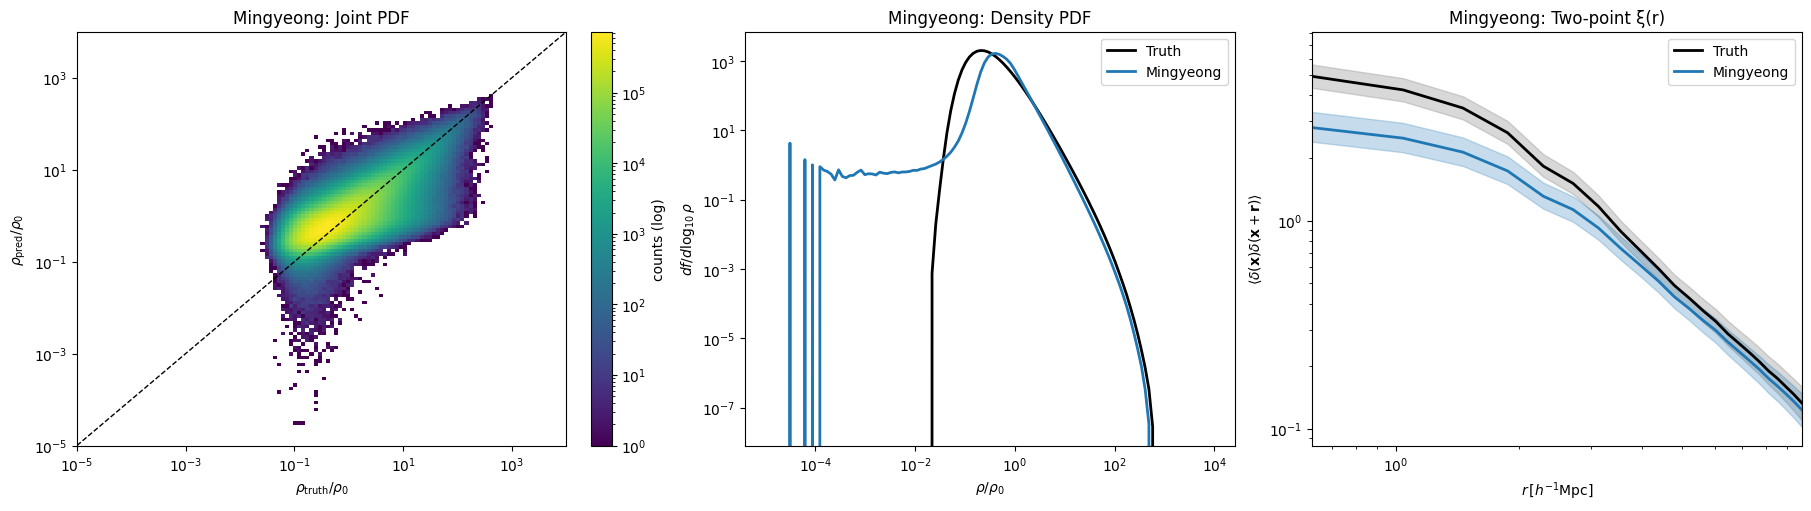

[14:25:53] INFO - [Mingyeong] row of 3 figures rendered.


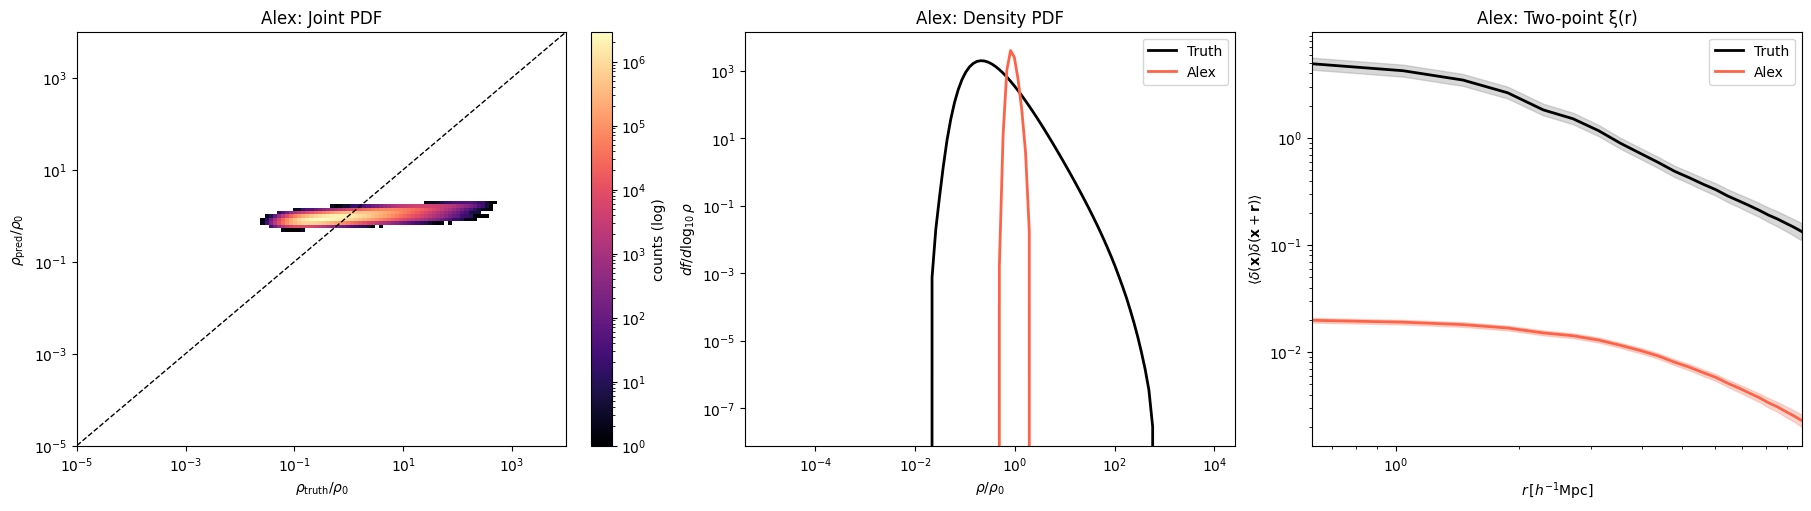

[14:25:55] INFO - [Alex] row of 3 figures rendered.
[14:25:55] INFO - All figures rendered (two 1×3 rows).


In [6]:
# ===== Cell 2: Side-by-side comparison (1×3 per case) =====
import numpy as np
import matplotlib.pyplot as plt
import logging

CACHE_NPZ = "figure5_cache_ming_vs_alex.npz"
logger = logging.getLogger("fig5_plot_side_by_side")
if not logger.handlers:
    h = logging.StreamHandler()
    h.setFormatter(logging.Formatter("[%(asctime)s] %(levelname)s - %(message)s", "%H:%M:%S"))
    logger.addHandler(h)
logger.setLevel(logging.INFO)

# ---------- Load ----------
dat = np.load(CACHE_NPZ)
RHO_EDGES = dat["RHO_EDGES"]
LOGT_EDGES, LOGP_EDGES = dat["LOGT_EDGES"], dat["LOGP_EDGES"]
H_joint_ming = dat["H_joint_ming"]
H_joint_alex = dat["H_joint_alex"]
H1_truth, H1_ming, H1_alex = dat["H1_truth"], dat["H1_ming"], dat["H1_alex"]
r = dat["r"]
XI_truth = dat["XI_truth"]; XI_ming = dat["XI_ming"]; XI_alex = dat["XI_alex"]
N_indices = int(dat["N_indices"])

logger.info(f"Loaded cache for N={N_indices} indices.")

# ---------- Precompute ----------
T_edges = 10**LOGT_EDGES
P_edges = 10**LOGP_EDGES
centers_rho = 0.5*(RHO_EDGES[1:] + RHO_EDGES[:-1])

def agg(X):
    med = np.nanmedian(X, axis=0)
    lo  = np.nanpercentile(X, 16, axis=0)
    hi  = np.nanpercentile(X, 84, axis=0)
    return med, lo, hi

t_med, t_lo, t_hi = agg(XI_truth)
m_med, m_lo, m_hi = agg(XI_ming)
a_med, a_lo, a_hi = agg(XI_alex)

# ---------- Plot function ----------
def plot_row(H_joint, H1_case, xi_med, xi_lo, xi_hi, label, color, cmap):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

    # (Left) Joint PDF
    H_plot = np.ma.masked_where(H_joint <= 0, H_joint)
    ax = axes[0]
    pcm = ax.pcolormesh(T_edges, P_edges, H_plot.T, shading='auto',
                        norm=plt.matplotlib.colors.LogNorm(), cmap=cmap)
    cb = fig.colorbar(pcm, ax=ax); cb.set_label("counts (log)")
    xmin, xmax = T_edges[0], T_edges[-1]
    ax.plot([xmin, xmax], [xmin, xmax], 'k--', lw=1)
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel(r"$\rho_{\rm truth}/\rho_0$")
    ax.set_ylabel(r"$\rho_{\rm pred}/\rho_0$")
    ax.set_title(f"{label}: Joint PDF")

    # (Middle) Density PDF
    ax = axes[1]
    ax.plot(centers_rho, H1_truth, color='black', lw=2, label='Truth')
    ax.plot(centers_rho, H1_case,  color=color, lw=2, label=label)
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel(r"$\rho/\rho_0$")
    ax.set_ylabel(r"$df/d\log_{10}\rho$")
    ax.set_title(f"{label}: Density PDF")
    ax.legend()

    # (Right) ξ(r)
    ax = axes[2]
    ax.fill_between(r, t_lo, t_hi, color='gray', alpha=0.3)
    ax.plot(r, t_med, color='black', lw=2, label='Truth')
    ax.fill_between(r, xi_lo, xi_hi, color=color, alpha=0.25)
    ax.plot(r, xi_med, color=color, lw=2, label=label)
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlim(max(r[1], 1e-3), r[-1])
    ax.set_xlabel(r"$r\,[h^{-1}\mathrm{Mpc}]$")
    ax.set_ylabel(r"$\langle \delta(\mathbf{x})\delta(\mathbf{x}+\mathbf{r}) \rangle$")
    ax.set_title(f"{label}: Two-point ξ(r)")
    ax.legend()

    plt.show()
    logger.info(f"[{label}] row of 3 figures rendered.")

# ---------- Draw both rows ----------
plot_row(H_joint_ming, H1_ming, m_med, m_lo, m_hi, "Mingyeong", "tab:blue", "viridis")
plot_row(H_joint_alex, H1_alex, a_med, a_lo, a_hi, "Alex", "tomato", "magma")

logger.info("All figures rendered (two 1×3 rows).")


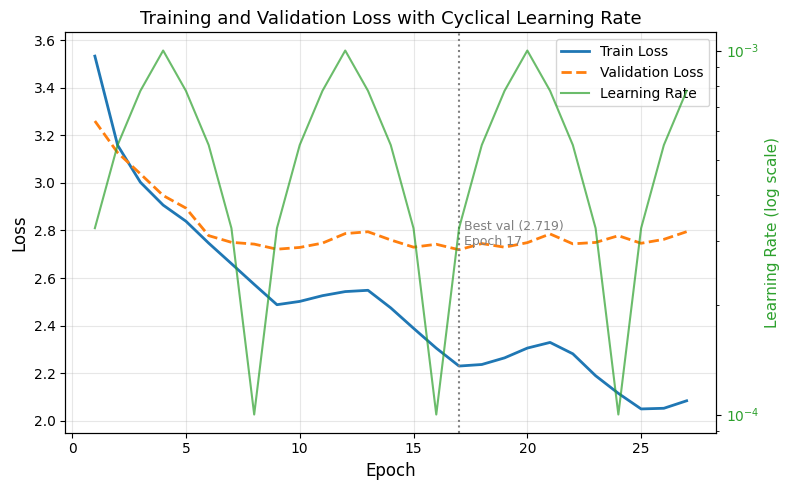

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# =========================================
# 파일 경로 설정
# =========================================
csv_path = "/home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit/20251014_210016/vitunet3d_tgt-rho_D128_ps8x8_st8x8_dim256_depth3_heads8_bs4_clr[1e-04-1e-03]_s42_smp100_log.csv"

# =========================================
# CSV 파일 읽기
# =========================================
df = pd.read_csv(csv_path)

# =========================================
# 최적 epoch 계산
# =========================================
best_epoch = df["val_loss"].idxmin()
best_val = df["val_loss"].min()

# =========================================
# 손실 및 학습률 시각화
# =========================================
fig, ax1 = plt.subplots(figsize=(8, 5))

# 손실 곡선
ax1.plot(df["epoch"], df["train_loss"], label="Train Loss", color="tab:blue", linewidth=2)
ax1.plot(df["epoch"], df["val_loss"], label="Validation Loss", color="tab:orange", linewidth=2, linestyle="--")

# 최소 validation loss 표시
ax1.axvline(df["epoch"][best_epoch], color="gray", linestyle=":", lw=1.5)
ax1.text(df["epoch"][best_epoch]+0.2, best_val+0.02,
         f"Best val ({best_val:.3f})\nEpoch {df['epoch'][best_epoch]}",
         color="gray", fontsize=9)

ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12)
ax1.set_ylim([df[["train_loss","val_loss"]].min().min()-0.1, df[["train_loss","val_loss"]].max().max()+0.1])
ax1.grid(alpha=0.3)

# =========================================
# 보조축: Learning Rate (log scale)
# =========================================
ax2 = ax1.twinx()
ax2.plot(df["epoch"], df["lr"], color="tab:green", label="Learning Rate", alpha=0.7, linewidth=1.5)
ax2.set_ylabel("Learning Rate (log scale)", color="tab:green", fontsize=11)
ax2.set_yscale("log")
ax2.tick_params(axis="y", labelcolor="tab:green")

# =========================================
# 범례 병합
# =========================================
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.title("Training and Validation Loss with Cyclical Learning Rate", fontsize=13)
plt.tight_layout()
plt.show()
